In [26]:
DATABASES = {
    "WindowsLog":"/mnt/d/Data/NLP/WindowsTop10000.log",
}

EMBEDDINGS = {
    "FastText":"/mnt/d/Data/NLP/crawl-300d-2M-subword.bin",
}


In [29]:
#Downloaded from https://fasttext.cc/docs/en/english-vectors.html
#Gensim supports loading fasttext model that can guess words not in dictionary with load_facebook_vectors() - .bin files
#but that model format has to include subword/model info such as crawl-300d-2M-subword.zip
#Alternatively, model that can not guess words not in dictionary can be loaded with KeyedVectors.load_word2vec_format(), such as crawl-300d-2M.vec.zip,
#usually .vec files similarly to GoogleNews above
#Explanation: https://stackoverflow.com/questions/62308418/word-embedding-with-gensim-and-fasttext-training-on-pretrained-vectors

#Loads in cca 6 mins
from gensim import models
fasttext = models.fasttext.load_facebook_vectors(EMBEDDINGS["FastText"])

In [ ]:
#Split according to spaces, no date or time gives 98945 tokens 3757 unique words
#Number of similar words is 690 for 0.25 threashold
#Split according to spaces, dash, underscore, slash, backslash and tilda, no date or time
#gives 164692 tokens 3800 unique words
import re
def split_log(log: str) -> list:
    return re.split(r'[\s~_\-/\\]+', log)

date_pattern = re.compile(r"\d{4}-\d{2}-\d{2}")
time_pattern = re.compile(r"\d{2}:\d{2}:\d{2},")
tokens = []
with open(DATABASES['WindowsLog'], 'r') as f:
    line = f.readline()
    while line:
        # Process the line
        words = split_log(line)
        filtered_words = [
            w for w in words
            if not (date_pattern.fullmatch(w) or time_pattern.fullmatch(w))
        ]
        tokens.extend(filtered_words)
        line = f.readline()
print(f"Tokens size: {len(tokens)}")
dictionary = sorted(list(set(tokens)))  # Remove duplicates
print(f"Dictionary size: {len(dictionary)}")
# Save the dictionary to a file
with open('./output/dictionary.txt', 'w') as f:
    for word in dictionary:
        f.write(f"{word}\n")

Tokens size: 164692
Dictionary size: 3800


In [44]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
n = len(dictionary)
distances = np.zeros((n, n))

def compute_distances(i, dictionary, distances, n):
    for j in range(i, n):
        dist = fasttext.distance(dictionary[i], dictionary[j])
        distances[i, j] = dist
        distances[j, i] = dist  # Symmetric

with ThreadPoolExecutor(24) as executor:
    for i in range(n):
        executor.submit(compute_distances, i, dictionary, distances, n)

# Save the distances to a file
np.save('./output/distances.npy', distances)

In [3]:
# Load the distances and dictionary from files
import numpy as np
distances = np.load('./output/distances.npy')
with open('./output/dictionary.txt', 'r') as f:
    dictionary = [line.strip() for line in f]

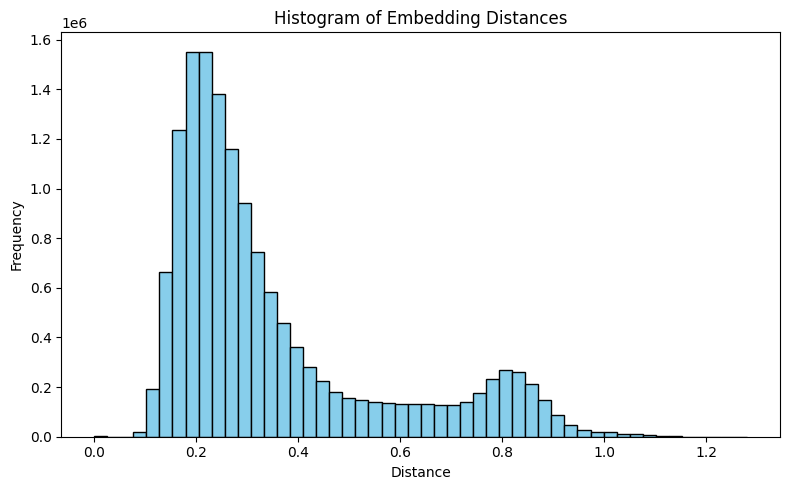

In [45]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(distances.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Embedding Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

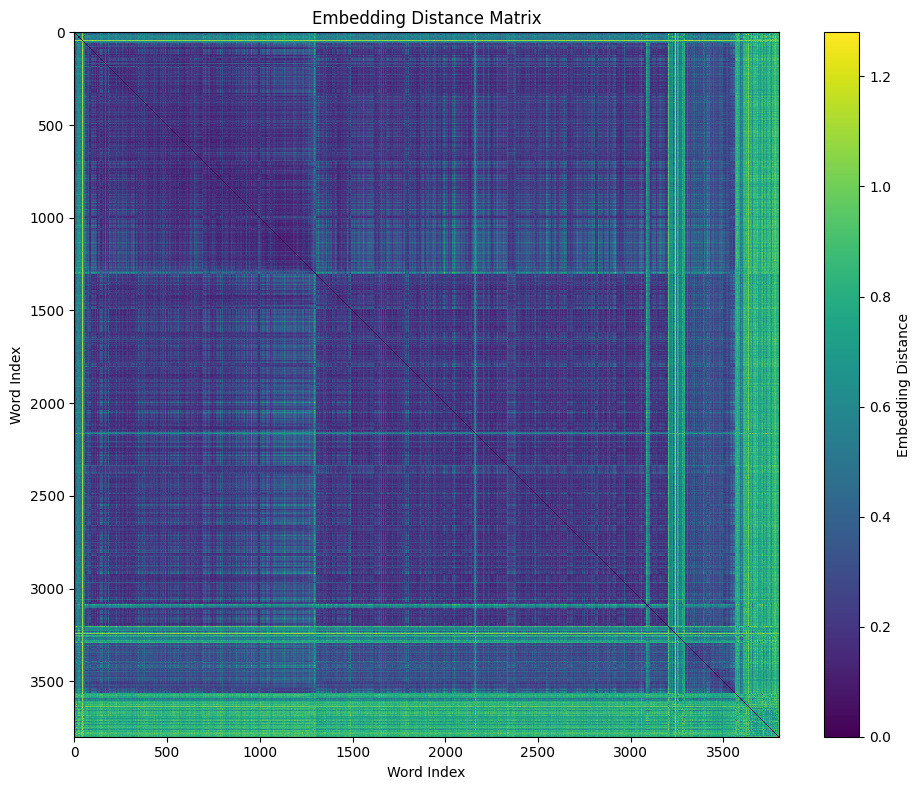

In [46]:
import numpy as np
import matplotlib.pyplot as plt
distances_array = np.array(distances)
plt.figure(figsize=(10, 8))
plt.imshow(distances_array, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Embedding Distance')
plt.title('Embedding Distance Matrix')
plt.xlabel('Word Index')
plt.ylabel('Word Index')
plt.tight_layout()
plt.show()

In [49]:
import re
pattern = re.compile(r"\d+_\d+")
similar_words:set = set()
with open('./output/similarities.txt', 'w') as f:
    for i in range(0, distances.shape[0]):
        for j in range(0, distances.shape[1]):
            if distances[i, j] < 0.25:  # Adjust threshold as needed
                if pattern.match(dictionary[i]) or pattern.match(dictionary[j] or dictionary[j] == dictionary[i]):
                    continue
                f.write(f"Similar words: {dictionary[i]} - {dictionary[j]} Similarity {distances[i, j]}\n")
                similar_words.add(dictionary[i])
                similar_words.add(dictionary[j])
print(f"Number of similar words: {len(similar_words)}")
print("Similar words:", sorted(similar_words))

Number of similar words: 3799
Similar words: ['"', "'", "'{bf1a281b", '(0x00000000002ec640)', '(0x00000000004c29e0)', '(0x000000000105d5b0)', '(0x00000000041429b0)', '(0x000000001aac01c0)', '(0x000000001cbbf2c0)', '(8):', '(call', '(flags', '(seq', '(stack', '(wcp.dll', '*', '0', '0,', '0.0.0.6)', '00000001@2016', '00000002', '00000002@2016', '00000003@2016', '00000004', '00000004,', '00000005', '00000006', '00000007@2016', '00000008', '00000008@2016', '00000009@2016', '0000000a', '0000000b', '0000000c', '0000000d', '0000000e', '0000000f@2016', '00000010@2016', '00000017', '0080c847b195}', '01', '02', '03', '09', '0:0', '0X1', '0x00000000', '0x00000000,', '0x2', '0x6', '0x80004005', '0x80070001', '0x800f0805', '0x800f080d', '1', '1)', '1),', '10', '100742769', '100772770', '100922779', '100952781', '100982782', '101102789', '101172793', '101232797', '101272799', '10127586', '101322802', '101632820', '101752826', '101792829', '101842832', '101902835', '1020020613', '102002841', '1023600

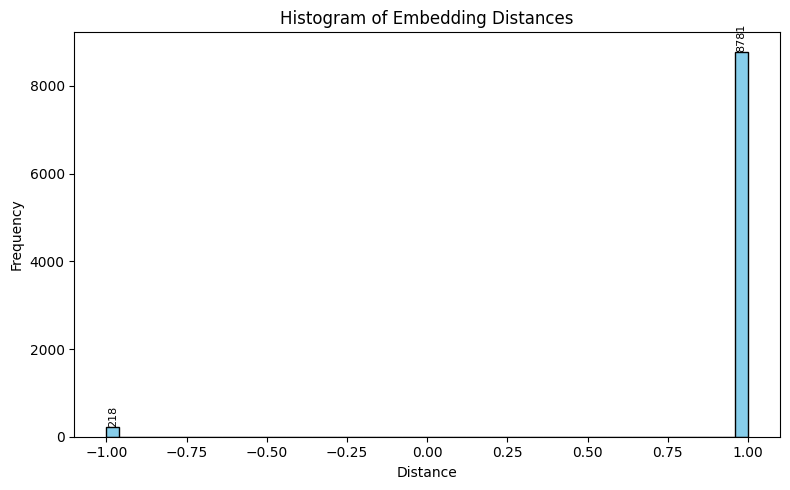

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import json
results = []
with open("./output/results.txt", "r") as f:
    for line in f:
        result = json.loads(line)
        results.append(result["anomaly_prediction"])

plt.figure(figsize=(8, 5))
counts, bins, patches = plt.hist(results, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Embedding Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.tight_layout()

# Add counts on top of columns
for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        plt.text((bin_left + bin_right) / 2, count, str(int(count)),
                 ha='center', va='bottom', fontsize=8, rotation=90)

plt.show()